# Topic Modeling
Topic modeling an unsupervised technique that is able to extract the hidden topics in large volumes of data. We will be using the Latent Dirichlet Allocation (LDA) implemented in gensim to explore which topics were dominant in the YouTube caption data. 

In [5]:
import pandas as pd

import re 
import nltk.corpus
from nltk.corpus import stopwords

from pprint import pprint
import gzip
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

## Import and clean data

In [6]:
video_captions = pd.read_csv("../data/caption_data.csv")

In [7]:
def text_cleaning(video_caption):
    if video_caption is not None:
        # normalize case
        video_caption = video_caption.lower()
        # remove punctuation
        video_caption = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", video_caption)
        # remove stopwords
        stop = stopwords.words('english')
        video_caption = " ".join([word for word in video_caption.split() if word not in (stop)])
        # lemmenization
        wn = nltk.WordNetLemmatizer()
        video_caption = " ".join([wn.lemmatize(word) for word in video_caption.split()])
    return video_caption

In [8]:
data_words = video_captions["text"].dropna().apply(text_cleaning).str.split(" ").to_list()

## Build bigram and trigram models 
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [10]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [11]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

## Create the Dictionary and Corpus needed for Topic Modeling

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('000', 1),
  ('24', 1),
  ('72', 1),
  ('750', 2),
  ('absolutely', 1),
  ('accepted', 1),
  ('accepting', 1),
  ('across', 2),
  ('actually', 2),
  ('adhere', 1),
  ('airline', 1),
  ('airport', 3),
  ('allowed', 1),
  ('almost', 2),
  ('always', 1),
  ('another', 5),
  ('answer', 2),
  ('answering', 1),
  ('anxiety', 1),
  ('anything', 1),
  ('apparently', 1),
  ('apps', 1),
  ('arrive', 2),
  ('arrived', 1),
  ('aside', 1),
  ('asked', 2),
  ('aspect', 1),
  ('assigned', 1),
  ('assuming', 1),
  ('attack', 1),
  ('austrian', 1),
  ('authority', 1),
  ('away', 1),
  ('awry', 1),
  ('back', 3),
  ('basically', 4),
  ('bathroom', 1),
  ('big', 2),
  ('border', 2),
  ('break', 1),
  ('bus', 5),
  ('cairo', 2),
  ('called', 1),
  ('calling', 2),
  ('came', 7),
  ('canada', 5),
  ('canadian', 5),
  ('canceled', 1),
  ('car', 1),
  ('cathy', 1),
  ('certain', 1),
  ('check', 1),
  ('checked', 1),
  ('checking', 2),
  ('checkpoint', 1),
  ('citizen', 1),
  ('clover', 1),
  ('code', 1),
 

## Building the Topic Model
We can provide parameters to tune the model. Alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior. Chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic. We can see the keywords for each topic and the importance of each keyword in the next cell.

In [14]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.008*"form" + 0.007*"get" + 0.007*"people" + 0.007*"go" + '
  '0.007*"vaccinated" + 0.007*"know" + 0.007*"planned" + 0.007*"number" + '
  '0.007*"one" + 0.007*"could"'),
 (1,
  '0.023*"virus" + 0.020*"china" + 0.020*"bat" + 0.017*"like" + 0.016*"lab" + '
  '0.014*"people" + 0.011*"coronavirus" + 0.011*"woman" + 0.011*"found" + '
  '0.009*"already"'),
 (2,
  '0.034*"uh" + 0.018*"vaccine" + 0.015*"africa" + 0.013*"country" + '
  '0.011*"question" + 0.010*"um" + 0.009*"people" + 0.009*"two" + '
  '0.008*"percent" + 0.008*"think"'),
 (3,
  '0.001*"uh" + 0.001*"vaccine" + 0.001*"people" + 0.001*"know" + 0.001*"um" + '
  '0.001*"get" + 0.001*"go" + 0.001*"africa" + 0.001*"question" + '
  '0.001*"country"'),
 (4,
  '0.001*"people" + 0.001*"get" + 0.001*"know" + 0.001*"uh" + 0.001*"vaccine" '
  '+ 0.001*"u" + 0.001*"mandate" + 0.001*"like" + 0.001*"going" + '
  '0.001*"time"'),
 (5,
  '0.031*"know" + 0.016*"get" + 0.012*"test" + 0.012*"uh" + 0.011*"said" + '
  '0.011*"going" + 0.011*"

## Compute Model Perplexity and Coherence Score
Coherence measures the degree of semantic similarity between high scoring words in the topic. These measurements help truly distinguish topics that are interpretable and understandable.

In [15]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.1701454159323905

Coherence Score:  0.3168800896992829


## Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. In the dashboard below, each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic. If we move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/home/asg003/.local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/asg003/.local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/asg003/.local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/asg003/.local/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/asg003/.local/lib/python3.9/site-packages/past/builtins/misc.py:

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.170137  0.022661       1        1  35.020119
2      0.139556  0.027066       2        1  33.095309
5      0.172011  0.049463       3        1  13.061669
1     -0.048116 -0.259653       4        1   5.831901
7      0.098088 -0.052438       5        1   5.830334
19    -0.147311  0.119828       6        1   3.472547
12     0.080955 -0.023617       7        1   3.151393
0     -0.013635  0.016607       8        1   0.471730
13    -0.043086 -0.002183       9        1   0.036794
4     -0.038170  0.008151      10        1   0.002676
9     -0.032252  0.010849      11        1   0.002661
10    -0.037184  0.007789      12        1   0.002605
6     -0.031219  0.008501      13        1   0.002589
15    -0.036049  0.009574      14        1   0.002581
18    -0.038960  0.010689      15        1   0.002549
8     -0.038952  0.007880      16        1   0.002547
14    -0.035075  0.010449      17        1   0.002543
17    -0.039038  0.010605      18        1   0.002515
3     -0.039269  0.007888      19        1   0.002473
16    -0.042433  0.009892      20        1   0.002465, topic_info=         Term        Freq       Total Category  logprob  loglift
672        uh  166.000000  166.000000  Default  30.0000  30.0000
1387  vaccine  113.000000  113.000000  Default  29.0000  29.0000
304        um  120.000000  120.000000  Default  28.0000  28.0000
152      know   99.000000   99.000000  Default  27.0000  27.0000
120       get   93.000000   93.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
286      test    0.000110   38.073092  Topic20  -7.6152  -2.1424
302       two    0.000110   40.580983  Topic20  -7.6174  -2.2083
59       come    0.000109   30.319106  Topic20  -7.6257  -1.9251
235     right    0.000109   31.841700  Topic20  -7.6256  -1.9740
341      also    0.000109   37.710512  Topic20  -7.6248  -2.1423

[1407 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1416      2  0.710434          1
1416      6  0.177609          1
831       1  0.971681         11
329       4  0.904739       2017
330       4  0.570169       2018
...     ...       ...        ...
2268      6  0.959073  yesterday
576       4  0.880691    youtube
577       4  1.020561     yunnan
681       2  0.927854       zero
681       7  0.103095       zero

[967 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 3, 6, 2, 8, 20, 13, 1, 14, 5, 10, 11, 7, 16, 19, 9, 15, 18, 4, 17])

## Find the optimal number of topics for LDA
Choosing a number of models that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Higher numbers of topics can sometimes provide more granular sub-topics. However, if the same keywords being repeated in multiple topics, the number of topics might be too high.

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=2, limit=40, step=6)

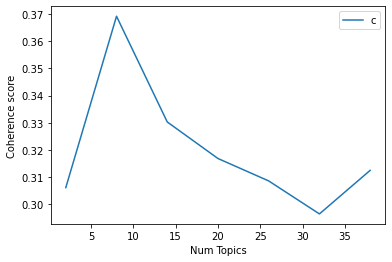

In [19]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3062
Num Topics = 8  has Coherence Value of 0.3692
Num Topics = 14  has Coherence Value of 0.3303
Num Topics = 20  has Coherence Value of 0.3169
Num Topics = 26  has Coherence Value of 0.3086
Num Topics = 32  has Coherence Value of 0.2965
Num Topics = 38  has Coherence Value of 0.3125


In [21]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.005*"get" + 0.005*"go" + 0.005*"people" + 0.005*"know" + '
  '0.005*"vaccinated" + 0.005*"one" + 0.005*"number" + 0.005*"year" + '
  '0.005*"need" + 0.005*"mean"'),
 (1,
  '0.001*"uh" + 0.001*"vaccine" + 0.001*"um" + 0.001*"people" + '
  '0.001*"country" + 0.001*"africa" + 0.001*"get" + 0.001*"know" + '
  '0.001*"question" + 0.001*"two"'),
 (2,
  '0.033*"uh" + 0.018*"vaccine" + 0.015*"africa" + 0.013*"country" + '
  '0.011*"question" + 0.010*"um" + 0.009*"people" + 0.009*"two" + '
  '0.008*"percent" + 0.008*"think"'),
 (3,
  '0.001*"uh" + 0.001*"vaccine" + 0.001*"know" + 0.001*"get" + 0.001*"um" + '
  '0.001*"people" + 0.001*"u" + 0.001*"go" + 0.001*"going" + 0.001*"question"'),
 (4,
  '0.021*"virus" + 0.018*"bat" + 0.018*"china" + 0.015*"like" + 0.014*"lab" + '
  '0.013*"people" + 0.010*"found" + 0.010*"woman" + 0.010*"coronavirus" + '
  '0.008*"already"'),
 (5,
  '0.029*"know" + 0.015*"get" + 0.012*"test" + 0.011*"uh" + 0.011*"u" + '
  '0.011*"going" + 0.011*"said" + 0.009*

## Finding the dominant topic in each sentence
One of the practical application of topic modeling is to determine what topic a given document is about. To find that, we find the topic number that has the highest percentage contribution in that document.

In [ ]:
caption_data = video_captions["text"].dropna().apply(text_cleaning)
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=caption_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=caption_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

## Find the most representative document for each topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

## Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed.

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics